# Project objectives


In this project we will try to understand what is the effect of Paypal's announcement to accept Bitcoins on their value.

Since a randomized experiment is not available, we will try to answer this question using a Bayesian structural time-series model. We will therefore use a set of control time series that have not been impacted by the same treatment (for example the price of other stocks that have had no impact from the Paypal announcement).

This model is then used to try and predict how the response metric would have evolved after the intervention if the intervention had never occurred. 

We will try to predict what the price of Bitcoins would have been if Paypal had never made the announcement and then we will compare this value with what actually happened


In [1]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

After loading and installing the necessary libraries, we will define the treatment dates.

We will use 2020-10-20 as the initial date of the treatment, which is the date of the announcement, and 2020-10-23 as the final date, which was a Friday.

We must then define a period to be used to train our model which must end the day before the treatment begins


In [2]:
# Define dates
training_start = "2020-09-01" #needs to be longehr that treatment period, the longer the better
training_end = "2020-10-19" # a day before treatment start

treatment_start = "2020-10-20"
treatment_end = "2020-10-23"

end_stock = "2020-10-24" # a day more the treatment end 

In [3]:
# loading financial data Bitcon
y = ["BTC-USD"]
y = yf.download(tickers = y, start= training_start, end=end_stock, intervat="1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
y = y['Adj Close'].rename('y')

We then used yfinance to upload Bitcoin prices for the period of interest. 

As a next step we have selected a group of shares, we will use their share price to create a control group to evaluate the effect of the treatment.

We have not selected other digital currencies because their price may have been impacted by the Paypal announcement. 

This is a first assumption that we have to make to use this model or that we assume that there is a set control time series that were themselves not affected by the intervention.

In [5]:
stocks = ["CARL-B.CO", "ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"] 
X = yf.download(tickers = stocks, start= training_start, end=end_stock, intervat="1d")

[*********************100%***********************]  9 of 9 completed


In [6]:
X.head()

Adj Close                                               \
             CARL-B.CO       CRSP          DE       GOOG         JD   
Date                                                                  
2020-09-01  816.406311  93.419998  211.929916  83.035500  80.459969   
2020-09-02  824.950073  93.930000  211.365265  86.414001  81.162254   
2020-09-03  840.708557  85.690002  205.231949  82.092003  77.094872   
2020-09-04  826.848633  82.019997  205.747910  79.552002  78.031250   
2020-09-07  835.392456        NaN         NaN        NaN        NaN   

                                                              Close  ...  \
                 KTOS          SQ       TRMB     ZAL.DE   CARL-B.CO  ...   
Date                                                                 ...   
2020-09-01  19.700001  166.660004  53.410000  77.000000  860.000000  ...   
2020-09-02  19.910000  162.880005  54.310001  77.000000  869.000000  ...   
2020-09-03  19.520000  152.860001  50.900002  75.080002  885.599976  ...   
2020-09-04  19.260000  146.389999  49.959999  71.739998  871.000000  ...   
2020-09-07        NaN         NaN        NaN  74.000000  880.000000  ...   

                 Open    Volume                                                \
               ZAL.DE CARL-B.CO       CRSP         DE        GOOG          JD   
Date                                                                            
2020-09-01  74.959999    269532   779500.0  1873400.0  36506000.0  11431400.0   
2020-09-02  77.500000    202539   532000.0  1983000.0  50224000.0  13860900.0   
2020-09-03  77.260002    248867  1278900.0  1975200.0  62156000.0  19254000.0   
2020-09-04  74.800003    221091  1570300.0  1662300.0  52172000.0  21500900.0   
2020-09-07  72.239998     90498        NaN        NaN         NaN         NaN   

                                                      
                 KTOS          SQ       TRMB  ZAL.DE  
Date                                                  
2020-09-01   587600.0  12306400.0   542300.0  790198  
2020-09-02   612800.0  11214800.0   728800.0  496554  
2020-09-03   847100.0  16421200.0  1220300.0  736259  
2020-09-04  1060000.0  17995200.0   914700.0  662250  
2020-09-07        NaN         NaN        NaN  362062  

[5 rows x 54 columns]

In [7]:
X = X.iloc[:, :len(stocks)]

In [8]:
X.columns = X.columns.droplevel()

In [9]:
X.head()

,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,816.406311,93.419998,211.929916,83.035500,80.459969,19.700001,166.660004,53.410000,77.000000
2020-09-02,824.950073,93.930000,211.365265,86.414001,81.162254,19.910000,162.880005,54.310001,77.000000
2020-09-03,840.708557,85.690002,205.231949,82.092003,77.094872,19.520000,152.860001,50.900002,75.080002
2020-09-04,826.848633,82.019997,205.747910,79.552002,78.031250,19.260000,146.389999,49.959999,71.739998
2020-09-07,835.392456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


In [10]:
df = pd.concat([y, X], axis=1).dropna()

In [11]:
df.head()

,y,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-09-01,11970.478516,816.406311,93.419998,211.929916,83.035500,80.459969,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,824.950073,93.930000,211.365265,86.414001,81.162254,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,840.708557,85.690002,205.231949,82.092003,77.094872,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,826.848633,82.019997,205.747910,79.552002,78.031250,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,821.532593,81.459999,204.677063,76.619499,74.344276,19.230000,139.110001,49.139999,73.440002


In [12]:
# datframe with only training data

df_training = df[df.index <= training_end]

After preparing our DataFrame to be able to train the model, we are going to evaluate the other assumptions. First we make sure we have a stationary series. For this we will use the Augmented Dickey–Fuller test.

In [13]:
# Stationality
from statsmodels.tsa.stattools import adfuller

In [14]:
pvalue = adfuller(x= df_training.y)[1]

In [15]:
alpha= 0.05
if pvalue > alpha:
    print('Failed to reject null H. Time series is not stationary')
else:
    print('Rejected null H. Time series is stationary')

Failed to reject null H. Time series is not stationary


Since our time series are not stationary, we will use the differencing method to remove trend and seasonality. We ensure that therefore the series move in the same direction because of the correlation and not because they follow the same trend.

In [16]:
#differencing to make time series stationary (dividing)
differencing = df_training.pct_change().dropna()

In [17]:
pvalue = adfuller(x= differencing.y)[1]
alpha= 0.05
if pvalue > alpha:
    print('Failed to reject null H. Time series is not stationary')
else:
    print('Rejected null H. Time series is stationary')

Rejected null H. Time series is stationary


In the next step we will create a correlation matrix and decide to keep only those companies whose share price has shown a strong correlation with the value of Bitcoins.



<AxesSubplot:>

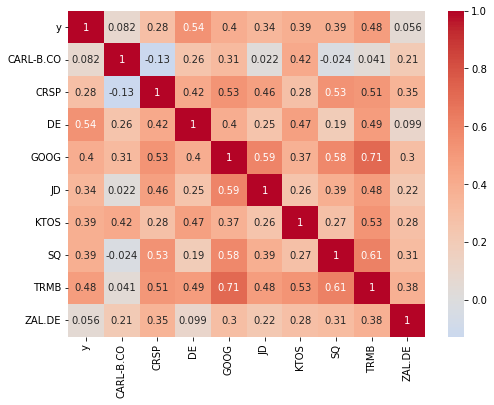

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(differencing.corr(), center=0, annot=True, cmap="coolwarm")

In [19]:
df_final = df.drop(columns=["ZAL.DE", "CARL-B.CO"])

In [20]:
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,211.929916,83.0355,80.459969,19.700001,166.660004,53.41


### We can now use our model to evaluate the impact of Paypal's announcement.

In [21]:
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [22]:
impact = CausalImpact(data=df_final, pre_period=pre_period, post_period=post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


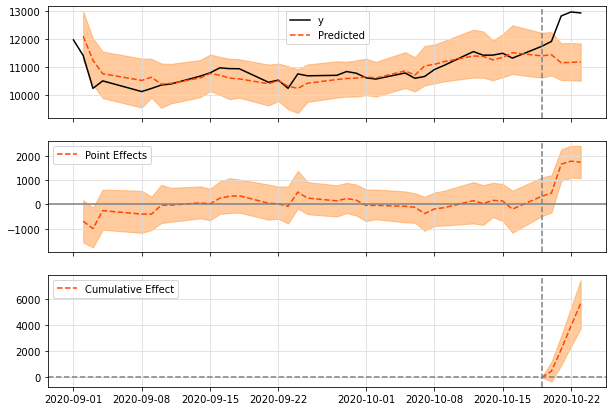

In [23]:
impact.plot()

# Conclusions

To interpret the result we can look at the second graph, which shows us how the Delta is different from zero. This indicates that the treatment had an effect on the historical series analysed.

In our case, the announcement made by Paypal that they would start accepting payments in Bitcoin had a positive impact on the price of coins.

If we look at the orange area, which represents the confidence interval,we can see that it is also different from zero and that therefore the result is statistically significant.

In [24]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11238.82 (231.96)  44955.29 (927.84)
95% CI                    [10801.28, 11710.55][43205.13, 46842.2]

Absolute effect (s.d.)    1420.54 (231.96)   5682.17 (927.84)
95% CI                    [948.81, 1858.08]  [3795.25, 7432.33]

Relative effect (s.d.)    12.64% (2.06%)     12.64% (2.06%)
95% CI                    [8.44%, 16.53%]    [8.44%, 16.53%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [25]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11238.82.
The 95% interval of this counterfactual prediction is [10801.28, 11710.55].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1420.54 with a 95% interval of
[948.81, 1858.08]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44955.29. The 95% interval of this prediction is [43205.13, 46842.2].


The above results are given in terms of absolute numbers. In relative
te